# 6. Decision Trees and Ensemble Learning
## Homework

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```

In [62]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
# import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_squared_error
import xgboost as xgb

%matplotlib inline

In [29]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-21 11:19:44--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'housing.csv.1'

housing.csv.1       100%[===================>]   1.36M  1.48MB/s    in 0.9s    

2022-10-21 11:19:46 (1.48 MB/s) - 'housing.csv.1' saved [1423529/1423529]



Use only the following columns:  
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`  

In [30]:
#@ READING DATASET:
PATH = './housing.csv'
features_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", 
                 "households", "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=features_cols)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


* Fill NAs with 0.

In [4]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
df.total_bedrooms = df.total_bedrooms.fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

* Apply the log tranform to `median_house_value`.

In [6]:
df.median_house_value = np.log1p(df.median_house_value)

* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.

In [7]:
def split_train_val_test(df, val_size, test_size, target, random_state):
    """
    Splits the dataset into 3 parts: train/validation/test with 
    (1-val_size-test_size)/val_size/test_size distribution. 
    Extracts the target variable from all datasets.
    """
    
    # Split the dataset into 2 parts: full_train/test with (train_size+val_size)/test_size distribution
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Split the full_train dataset into 2 parts: train/val with train_size/val_size distribution
    df_train, df_val = train_test_split(df_full_train, test_size=val_size/(1-test_size), random_state=random_state)
    
    # Verify the lenghts of datasets
    print(len(df_train), len(df_val), len(df_test))
    
    # Reset indices of all datasets 
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_full_train = df_full_train.reset_index(drop=True)
    
    # Extract target variable from all datasets 
    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    # Delete target variable from all datasets 
    del df_train[target]
    del df_val[target]
    del df_test[target]
    
    return df_full_train, df_train, df_val, df_test, y_train, y_val, y_test

In [8]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test =\
            split_train_val_test(df, 0.2, 0.2, 'median_house_value', 1)

12384 4128 4128


- We will use `DictVectorizer` to turn train and validation into matrices.

In [31]:
# use DictVectorizer to turn train and validation into matrices
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [10]:
#@ TRAINING THE REGRESSION MODEL:
dtreg = DecisionTreeRegressor(max_depth=1)
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [32]:
dv.feature_names_

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [33]:
dv.get_feature_names() # is deprecated, use get_feature_names_out instead

/Users/annazaretskaya/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [38]:
dv.get_feature_names_out().tolist()

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [39]:
#@ INSPECTION:
print(export_text(dtreg, feature_names=dv.feature_names_))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



- Which feature is used for splitting the data?

**Answer 1.** The feature `ocean_proximity=INLAND` is used for splitting the data.

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [12]:
#@ TRAINING RANDOM FOREST MODEL:
rfreg = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfreg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [13]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [14]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = rfreg.predict(X_val)
rmse(y_val, y_pred).round(2)

0.25

- What's the RMSE of this model on validation?

**Answer 2.** The RMSE of this model on validation set is **0.25**

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [15]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []

for n in range(10, 201, 10):
    rfreg = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rfreg.fit(X_train, y_train)
    y_pred = rfreg.predict(X_val)    
    
    scores.append((n, rmse(y_val, y_pred)))

In [16]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores

,n_estimators,rmse
0,10,0.245792
1,20,0.239150
2,30,0.235651
3,40,0.234542
4,50,0.233054
5,60,0.232915
6,70,0.232499
7,80,0.232567
8,90,0.232220
9,100,0.231943


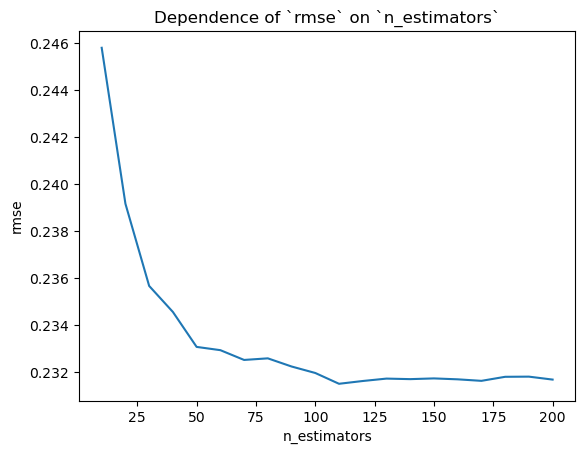

In [17]:
#@ INSPECTING THE RMSE SCORES:
plt.title('Dependence of `rmse` on `n_estimators`')
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.xlabel('n_estimators')
plt.ylabel('rmse');

- After which value of `n_estimators` does RMSE stop improving?

**Answer 3.** After `n_estimators = 110` RMSE stops improving (answer = 70).

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [18]:
#@ TRAINING THE MODEL WITH DEPTH:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rfreg = RandomForestRegressor(n_estimators=n,
                                      max_depth=d,
                                      random_state=1, 
                                      n_jobs=-1)
        rfreg.fit(X_train, y_train)
        y_pred = rfreg.predict(X_val)    
        
        scores.append((d, n, rmse(y_val, y_pred)))

In [40]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [41]:
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.254601
1,10,20,0.252599
2,10,30,0.251514
3,10,40,0.250963
4,10,50,0.250117
...,...,...,...
75,25,160,0.231489
76,25,170,0.231449
77,25,180,0.231583
78,25,190,0.231552


In [42]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['rmse'])
df_scores_pivot.round(3)

rmse                     
max_depth        10     15     20     25
n_estimators                            
10            0.255  0.245  0.246  0.246
20            0.253  0.239  0.239  0.238
30            0.252  0.237  0.236  0.235
40            0.251  0.236  0.235  0.234
50            0.250  0.235  0.234  0.233
60            0.250  0.235  0.233  0.233
70            0.250  0.234  0.233  0.232
80            0.250  0.234  0.233  0.232
90            0.249  0.234  0.233  0.232
100           0.249  0.234  0.232  0.232
110           0.249  0.233  0.232  0.231
120           0.249  0.233  0.232  0.231
130           0.249  0.233  0.232  0.231
140           0.249  0.233  0.232  0.231
150           0.249  0.233  0.232  0.231
160           0.249  0.233  0.232  0.231
170           0.249  0.233  0.232  0.231
180           0.249  0.233  0.232  0.232
190           0.249  0.233  0.232  0.232
200           0.249  0.233  0.232  0.231

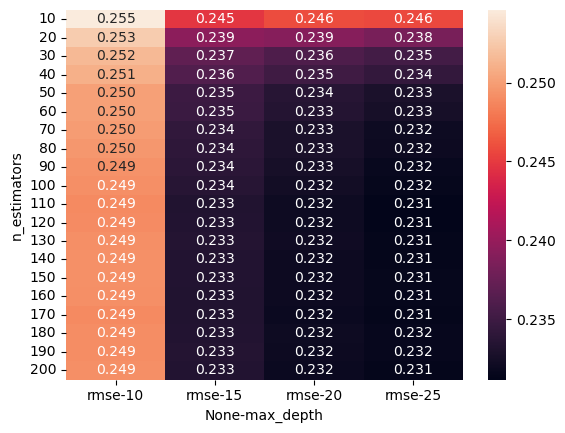

In [44]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f");

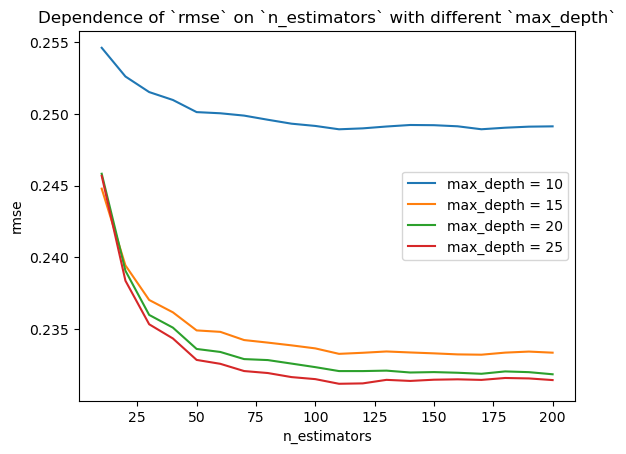

In [45]:
plt.title('Dependence of `rmse` on `n_estimators` with different `max_depth`')
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label=f'max_depth = {d}')

plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('rmse');

- What's the best `max_depth`:

**Answer 4.** The best `max_depth` is **25**.

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [46]:
#@ TRAINING THE RANDOM FOREST MODEL:
rfreg = RandomForestRegressor(n_estimators=10, 
                              max_depth=20,
                              random_state=1,
                              n_jobs=-1)
rfreg.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [47]:
# features = dv.get_feature_names_out()

features = dv.feature_names_
feature_importances = rfreg.feature_importances_

In [48]:
columns = ['feature', 'importance']
df_fi = pd.DataFrame(zip(features, feature_importances), columns=columns)

df_fi.sort_values('importance', ascending=False)

,feature,importance
4,median_income,0.363224
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101333
3,longitude,0.096341
1,housing_median_age,0.033197
10,population,0.030999
12,total_rooms,0.020465
11,total_bedrooms,0.019373
0,households,0.016141
9,ocean_proximity=NEAR OCEAN,0.004452


In [25]:
# using pd.Series
fi = pd.Series(feature_importances, index=features)
fi.sort_values(ascending=False)

median_income                 0.363224
ocean_proximity=INLAND        0.310901
latitude                      0.101333
longitude                     0.096341
housing_median_age            0.033197
population                    0.030999
total_rooms                   0.020465
total_bedrooms                0.019373
households                    0.016141
ocean_proximity=NEAR OCEAN    0.004452
ocean_proximity=<1H OCEAN     0.002765
ocean_proximity=NEAR BAY      0.000453
ocean_proximity=ISLAND        0.000357
dtype: float64

- What's the most important feature?

**Answer 5.** The most important feature is **median_income**.

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [52]:
features = dv.feature_names_

In [50]:
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=<1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms']

In [54]:
features[5] = 'ocean_proximity_within_1H OCEAN'

In [55]:
# Create DMatrix for train and validation
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [56]:
# Create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [57]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [106]:
%%capture output 
#we must put cell magics at the beginning of a cell

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [110]:
scores = {}
scores['eta=0.3'] = parse_xgb_output(output)
scores['eta=0.3']

,num_iter,train_rmse,val_rmse
0,0,8.12733,8.13245
1,5,1.40218,1.40741
2,10,0.34481,0.35782
3,15,0.23555,0.26044
4,20,0.21580,0.24624
5,25,0.20395,0.24099
6,30,0.19440,0.23741
7,35,0.18637,0.23562
8,40,0.17983,0.23419
9,45,0.17468,0.23279


- Now, change eta first to 0.1 and then to 0.01.

In [117]:
%%capture output 

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [118]:
scores['eta=0.1'] = parse_xgb_output(output)
scores['eta=0.1']

,num_iter,train_rmse,val_rmse
0,0,10.44372,10.44938
1,5,6.17513,6.17987
2,10,3.65741,3.66135
3,15,2.17500,2.17928
4,20,1.30499,1.31054
5,25,0.79933,0.80657
6,30,0.51144,0.52189
7,35,0.35700,0.37264
8,40,0.27984,0.30053
9,45,0.24350,0.26829


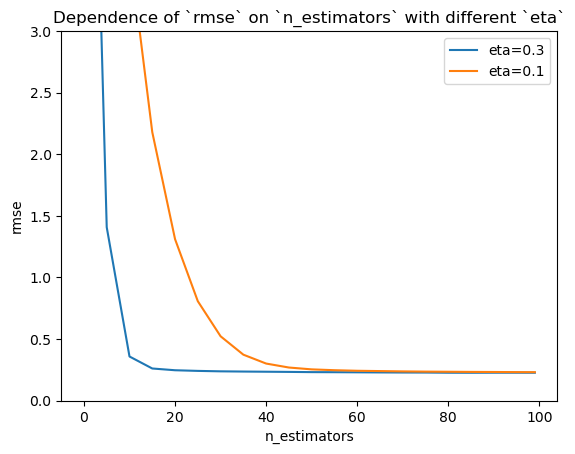

In [119]:
plt.title('Dependence of `rmse` on `n_estimators` with different `eta`')

for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)
    
plt.ylim(0, 3)

plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('rmse');

- Which eta leads to the best RMSE score on the validation dataset?

**Answer 6.** `eta = 0.3` leads to the best RMSE score on the validation dataset.